In [1016]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-white')
import dateutil
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
from schemdraw import flow, Drawing
import json

In [792]:
# Color scheme across plots
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

# qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
# qval_gtol = data['fdr corrected pval effect of glucose tolerance']
# qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

# Melt (un-pivot) the animal phenotypes df into long-form for each data type used in a phenotype plot

In [967]:
dfs = {}
for regex_str, data_name, col_names, cols_to_keep in [
    ('^RBG', 'RBG', [4, 8, 9, 10, 11, 12], [8, 9, 10]),
    ('^FBG', 'FBG', [8, 9, 10, 11, 12], [8, 9, 10]),
    ('Weightprefast', 'weight', [8, 9, 10, 11, 12], [8, 9, 10, 11, 12]),
    ('OGTT\(', 'OGTT',   [0, 10, 20, 30, 60, 120], [0, 10, 20, 30, 60, 120]),
    ('Insulin\(', 'ITT', [0, 10, 20, 30, 60, 120], [0, 10, 20, 30, 60, 120]),
    ('InsulinRBG', 'Rinsulin', [8, 9, 10, 11, 12], [8, 9, 10]),
    ('InsulinFBG', 'Finsulin', [8, 9, 10, 11, 12], [8, 9, 10]),
    ]:
    
    df = ap.loc[ap.index.isin(animals_used), 
                ap.filter(regex=regex_str).columns]
    df.columns = col_names
    df = df.loc[:, cols_to_keep]
    df = df.melt(var_name='x', value_name='y', ignore_index=False).reset_index()
    df['dummy'] = 'dummy'
    df['gluc_tol'] = df['animal'].map(ap['glucose_tolerance'])
    df['ogtt_rank'] = df['animal'].map(ap['ogtt_rank'])
    df = df.sort_values('gluc_tol', ascending=False)
    display(df)
    dfs[data_name] = df

,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,86.000000,dummy,normal,1.0
27,1093,10,69.500000,dummy,normal,2.0
25,1091,10,71.500000,dummy,normal,1.0
5,1091,8,108.500000,dummy,normal,1.0
7,1093,8,82.000000,dummy,normal,2.0
17,1093,9,83.000000,dummy,normal,2.0
1,1062,8,256.500000,dummy,impaired,5.0
26,1092,10,59.000000,dummy,impaired,3.0
22,1074,10,205.500000,dummy,impaired,4.0
21,1062,10,139.500000,dummy,impaired,5.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,63.000000,dummy,normal,1.0
27,1093,10,56.500000,dummy,normal,2.0
25,1091,10,48.500000,dummy,normal,1.0
5,1091,8,53.333333,dummy,normal,1.0
7,1093,8,47.000000,dummy,normal,2.0
17,1093,9,64.000000,dummy,normal,2.0
1,1062,8,52.333333,dummy,impaired,5.0
26,1092,10,51.500000,dummy,impaired,3.0
22,1074,10,55.000000,dummy,impaired,4.0
21,1062,10,40.000000,dummy,impaired,5.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
25,1091,10,86.2,dummy,normal,1.0
7,1093,8,75.6,dummy,normal,2.0
27,1093,10,85.7,dummy,normal,2.0
17,1093,9,81.0,dummy,normal,2.0
15,1091,9,81.2,dummy,normal,1.0
35,1091,11,89.0,dummy,normal,1.0
37,1093,11,90.4,dummy,normal,2.0
5,1091,8,76.1,dummy,normal,1.0
45,1091,12,92.4,dummy,normal,1.0
47,1093,12,94.5,dummy,normal,2.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
27,1093,20,221.0,dummy,normal,2.0
7,1093,0,50.0,dummy,normal,2.0
15,1091,10,172.5,dummy,normal,1.0
37,1093,30,268.5,dummy,normal,2.0
45,1091,60,195.0,dummy,normal,1.0
47,1093,60,300.5,dummy,normal,2.0
35,1091,30,208.0,dummy,normal,1.0
17,1093,10,139.5,dummy,normal,2.0
25,1091,20,201.5,dummy,normal,1.0
5,1091,0,72.0,dummy,normal,1.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
27,1093,20,2.6260,dummy,normal,2.0
7,1093,0,1.1070,dummy,normal,2.0
15,1091,10,5.0080,dummy,normal,1.0
37,1093,30,2.3100,dummy,normal,2.0
45,1091,60,8.5090,dummy,normal,1.0
47,1093,60,5.8720,dummy,normal,2.0
35,1091,30,5.8610,dummy,normal,1.0
17,1093,10,4.8310,dummy,normal,2.0
25,1091,20,6.9690,dummy,normal,1.0
5,1091,0,1.2900,dummy,normal,1.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,22.800,dummy,normal,1.0
27,1093,10,12.910,dummy,normal,2.0
25,1091,10,21.670,dummy,normal,1.0
5,1091,8,13.610,dummy,normal,1.0
7,1093,8,11.060,dummy,normal,2.0
17,1093,9,11.140,dummy,normal,2.0
1,1062,8,10.370,dummy,impaired,5.0
26,1092,10,19.330,dummy,impaired,3.0
22,1074,10,13.630,dummy,impaired,4.0
21,1062,10,11.560,dummy,impaired,5.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,1.7580,dummy,normal,1.0
27,1093,10,1.2570,dummy,normal,2.0
25,1091,10,1.1650,dummy,normal,1.0
5,1091,8,0.9529,dummy,normal,1.0
7,1093,8,0.8927,dummy,normal,2.0
17,1093,9,0.9694,dummy,normal,2.0
1,1062,8,4.1540,dummy,impaired,5.0
26,1092,10,1.0550,dummy,impaired,3.0
22,1074,10,1.3920,dummy,impaired,4.0
21,1062,10,1.9770,dummy,impaired,5.0


(<Figure size 576x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

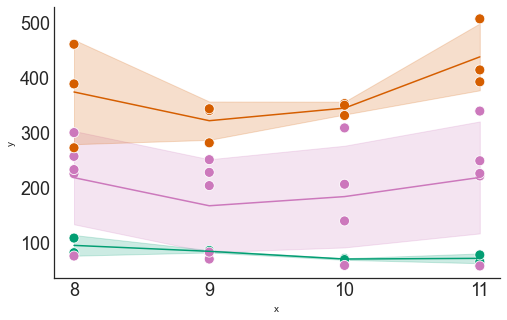

In [962]:
def make_metadata_plot(data, xvals, xlabel, ylabel, offsets=[-0.12, 0, 0.12], errorbar=True): 
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    fig.set_facecolor('white')
    for gluc_tol, animals, offset in zip(['normal', 'impaired', 'diabetic'], 
                                         [normal, impaired, diabetic], 
                                         offsets):
        df = data.loc[animals]
        color = colors[gluc_tol]
        x = [xval + offset for xval in xvals]
        if errorbar: 
            ax.errorbar(x, 
                df.mean(),
                yerr=df.std(), 
        #         capsize=4, capthick=2,
                fmt='-', linewidth=2, c=color, alpha=0.8, label=gluc_tol)
        for animal in animals:
            ax.scatter(x, df.loc[animal], color=color)
    plt.xticks(xvals, xvals, fontsize=18)
    plt.xlabel(xlabel, fontsize=20)
    plt.yticks(fontsize=16)
    ax.set_title(ylabel, fontsize=18, loc='left')
    plt.legend(loc=(1.01, 0.5), fontsize=17)
    sns.despine()
    return fig, ax

def make_ci_metadata_plot(df, x, y, ci='sd'):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    lp = sns.lineplot(
        data=df, x=x, y=y,
        hue='gluc_tol',
        palette=colors,
        n_boot=100, ci=ci, legend=False,
        ax=ax)
    sp = sns.scatterplot(
        data=df, x=x, y=y,
        size='dummy', sizes=[100],  
        hue='gluc_tol', palette=colors, 
        legend=False, ax=ax)
    plt.xticks(ticks=df[x].unique(), fontsize=18)
#     plt.xlabel(xlabel, fontsize=20)
    plt.yticks(fontsize=18)
#     plt.ylabel(ylabel, fontsize=20)
#     plt.legend(loc=(1.01, 0.0), markerscale=1.8, fontsize=20)
    sns.despine()
    return fig, ax

make_ci_metadata_plot(dfs['RBG'], x='x', y='y')

In [963]:
sns.color_palette('a', 10)

ValueError: a is not a valid palette name

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


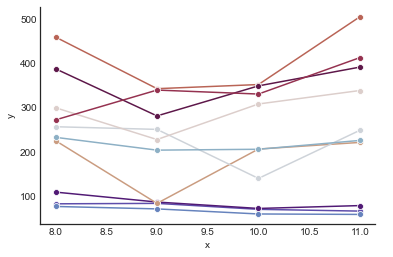

In [868]:
df = dfs['RBG']
# df['animal'] = df['animal'].astype('str')

# sns.scatterplot(
#     x='x', y='y', data=df,
#     hue='ogtt_rank', palette=ogtt_rank_colors,
#     legend=False,
# )
sns.lineplot(
    x='x', y='y', data=df,
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, 
)

plt.legend(loc=(1.01, 0.1))
sns.despine()

# Combine all plots into one figure

(0.0, 63457.25)

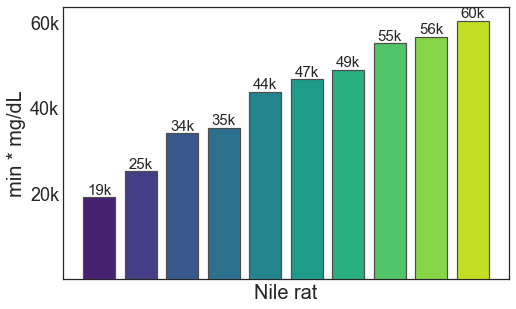

In [964]:
plt.gcf().set_size_inches(8, 5)
plt.bar(x=bar_data['loc'], height=bar_data['OGTT (AUC)'], 
        color=bar_data['color'].to_list(), edgecolor=(0.3, 0.3, 0.3), linewidth=1.2,
        width=0.77,
        zorder=10)
for loc, ogtt in zip(bar_data['loc'], bar_data['OGTT (AUC)']):
    plt.annotate(str(int(round(ogtt, -3)))[:2] + 'k', xy=(loc, ogtt+800), ha='center', fontsize=15, zorder=9)
    
plt.xlabel('Nile rat', fontsize=20)
plt.xticks([])
plt.ylabel('min * mg/dL', fontsize=20)
# plt.yticks(fontsize=16)
plt.yticks([20000, 40000, 60000], labels=['20k', '40k', '60k'], fontsize=18)
plt.ylim(0, plt.ylim()[1] + 200)

In [965]:
cmap = sns.color_palette('viridis', 10)  # twilight_shifted  coolwarm
display(cmap)
d1 = {str(rank):   color for rank, color in zip(range(1, 11), cmap)}
d2 = {float(rank): color for rank, color in zip(range(1, 11), cmap)}
ogtt_rank_colors = {**d1, **d2}  # Make string and float for redundancy

bar_data = ap.loc[ap.index.isin(animals_used), 
                  ['OGTT (AUC)', 'Insulin (AUC)', 'ogtt_rank', 'Interscapular brown fat (g)', 
                   'BF (%BW)', 'Inguinal white fat one side (g)', 'WF (%BW)', 'BF/WF']]
bar_data['loc'] = [str(x) for x in range(10)]
bar_data = bar_data.reset_index()
bar_data['animal'] = bar_data['animal'].astype('str')
bar_data['color'] = bar_data['ogtt_rank'].map(ogtt_rank_colors)
bar_data = bar_data.sort_values('OGTT (AUC)')
bar_data

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

,animal,OGTT (AUC),Insulin (AUC),ogtt_rank,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,loc,color
5,1091,19060.0,653.495,1.0,1.4930,1.615801,0.5354,0.579437,2.788569,5,"(0.283072, 0.130895, 0.449241)"
7,1093,25057.5,453.485,2.0,1.1374,1.203598,0.5462,0.577989,2.082387,7,"(0.262138, 0.242286, 0.520837)"
6,1092,34022.5,1316.550,3.0,1.2902,1.312513,0.6312,0.642116,2.044043,6,"(0.220057, 0.343307, 0.549413)"
2,1074,35250.0,626.660,4.0,2.5060,2.269928,0.7164,0.648913,3.498046,2,"(0.177423, 0.437527, 0.557565)"
1,1062,43717.5,432.020,5.0,2.5185,2.308433,0.7439,0.681852,3.385536,1,"(0.143343, 0.522773, 0.556295)"
9,1102,46565.0,377.030,6.0,1.7053,1.405853,0.8780,0.723825,1.942255,9,"(0.119512, 0.607464, 0.540218)"
0,1060,48742.5,422.940,7.0,2.0448,1.945576,0.7185,0.683635,2.845929,0,"(0.166383, 0.690856, 0.496502)"
8,1101,55007.5,153.906,8.0,0.9262,0.838190,0.6216,0.562534,1.490026,8,"(0.319809, 0.770914, 0.411152)"
4,1082,56462.5,198.650,9.0,0.8904,0.818382,0.6515,0.598805,1.366692,4,"(0.525776, 0.833491, 0.288127)"
3,1076,60245.0,238.005,10.0,1.4332,1.278501,0.6960,0.620874,2.059195,3,"(0.762373, 0.876424, 0.137064)"


C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


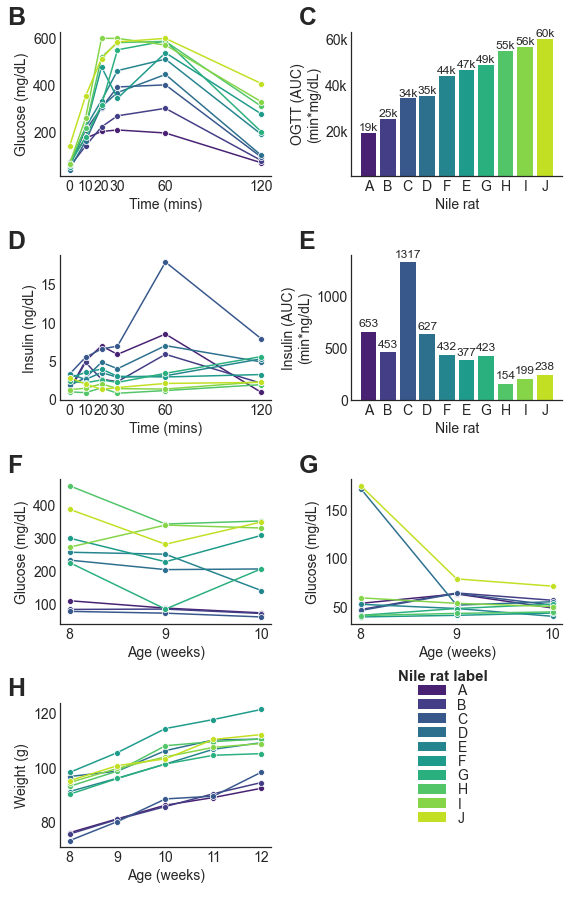

In [1047]:
nrows, ncols = 4, 2
fig, a = plt.subplots(nrows=nrows, ncols=ncols, gridspec_kw={'hspace': 0.55, 'wspace': 0.38})
fig.set_size_inches(9, 15)

### 1 ###
ax = a[0//ncols][0%ncols]
sns.lineplot(
    data=dfs['OGTT'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
ax.set_xticks(ticks=dfs['OGTT']['x'].unique())
ax.set_xlabel('Time (mins)', fontsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=14)
# ax.set_title('test', fontsize=20)

### 2 ###
ax = a[1//ncols][1%ncols]
ax.bar(x=bar_data['loc'], height=bar_data['OGTT (AUC)'], color=bar_data['color'].to_list())
for loc, ogtt in zip(bar_data['loc'], bar_data['OGTT (AUC)']):
    ax.annotate(str(int(round(ogtt, -3)))[:2] + 'k', xy=(loc, ogtt+1100), ha='center', fontsize=12, zorder=9)
ax.set_xticks(ticks=range(10), labels=[x for x in 'ABCDFEGHIJ'], fontsize=14)
ax.set_xlabel('Nile rat', fontsize=14)
ax.set_yticks(ticks=ax.get_yticks()[2::2], labels=[str(int(x/1000)) + 'k' for x in ax.get_yticks()[2::2]])
ax.set_ylabel('OGTT (AUC)\n(min*mg/dL)', fontsize=14) 

### 3 ###
ax = a[2//ncols][2%ncols]
sns.lineplot(
    data=dfs['ITT'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
ax.set_xticks(ticks=dfs['ITT']['x'].unique())
ax.set_xlabel('Time (mins)', fontsize=14)
ax.set_ylabel('Insulin (ng/dL)', fontsize=14)

### 4 ###
ax = a[3//ncols][3%ncols]
ax.bar(x=bar_data['loc'], height=bar_data['Insulin (AUC)'], color=bar_data['color'].to_list(),)
for loc, ogtt in zip(bar_data['loc'], bar_data['Insulin (AUC)']):
    ax.annotate(str(int(round(ogtt, 0))), xy=(loc, ogtt+50), ha='center', fontsize=12, zorder=9)
ax.set_xticks(ticks=range(10), labels=[x for x in 'ABCDFEGHIJ'], fontsize=14)
ax.set_xlabel('Nile rat', fontsize=14)
ax.set_ylabel('Insulin (AUC)\n(min*ng/dL)', fontsize=14)

### 5 ###
ax = a[4//ncols][4%ncols]
sns.lineplot(
    data=dfs['RBG'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
ax.set_xticks([8, 9, 10])
ax.set_xlabel('Age (weeks)', fontsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=14)

### 6 ###
ax = a[5//ncols][5%ncols]
sns.lineplot(
    data=dfs['FBG'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
ax.set_xticks([8, 9, 10])
ax.set_xlabel('Age (weeks)', fontsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=14)

### 7 ###
ax = a[6//ncols][8%ncols]
sns.lineplot(
    data=dfs['weight'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
ax.set_xlabel('Age (weeks)', fontsize=14)
ax.set_ylabel('Weight (g)', fontsize=14)

a[-1][-1].remove()
    
for i, letter in enumerate('BCDEFGHIJKLMNOP'[0:nrows*ncols-1]):
    ax = a[i//ncols][i%ncols]
#     ax.set_title(letter, loc='left', fontsize=25, fontweight='bold')
    ax.annotate(letter, xy=(-0.25, 1.05), xycoords='axes fraction', fontsize=25, fontweight='bold')
    ax.tick_params(labelsize=14)

legend_patches = []
for color, label in zip(cmap, 'ABCDEFGHIJ'):
    legend_patches.append(
        Patch(facecolor=color, edgecolor=None, label=label))
fig.legend(handles=legend_patches, loc=(0.69, 0.08), 
           title='Nile rat label',  title_fontproperties={'weight': 'bold', 'size': 15},
           fontsize=14, markerscale=1.5, labelspacing=0.01)
    
sns.despine()
plt.tight_layout()

# plt.savefig(r'..\reports\figures\0-1-1\all_phenotypes.svg', bbox_in tight', dpi=150, facecolor='white')

In [1035]:
# ax = a[6//ncols][6%ncols]
# sns.lineplot(
#     data=dfs['Rinsulin'], x='x', y='y',
#     hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
# ax.set_xticks([8, 9, 10, 11])
# ax = a[7//ncols][7%ncols]
# sns.lineplot(
#     data=dfs['Finsulin'], x='x', y='y',
#     hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', legend=False, ax=ax)
# ax.set_xticks([8, 9, 10, 11])
# ax = a[9//ncols][9%ncols]
# ax.bar(x=bar_data['loc'], height=bar_data['BF (%BW)'], color=bar_data['color'].to_list(),)
# for loc, ogtt in zip(bar_data['loc'], bar_data['OGTT (AUC)']):
#     a[i//ncols][i%ncols].annotate(str(int(round(ogtt, -3)))[:2] + 'k', xy=(loc, ogtt+800), ha='center', fontsize=15, zorder=9)
# ax.set_xticks([])
# ax = a[10//ncols][10%ncols]
# ax.bar(x=bar_data['loc'], height=bar_data['WF (%BW)'], color=bar_data['color'].to_list(),)
# ax.set_xticks([])
### L ###
# ax = a[11//ncols][11%ncols]
# ax.remove()
# ax.bar(x=bar_data['loc'], height=bar_data['BF/WF'], color=bar_data['color'].to_list(),)
# ax.set_xticks([])

A = OGTT test results

B = OGTT AUC 

C = Insulin test result

D = ITT (insulin tolerance test) AUC
E = Random-fed weekly blood glucose

F = Fasted weekly blood glucose

G = Random-fed weekly insulin

H = Fasted weekly insulin 

I = body weight over time

J = % of bodyweight that is Brown fat

K = % of bodyweight that is White fat

L will be for the legend, saying that each color = 1 animal 

In [993]:
ap.columns

Index(['Date of birth', 'litter', 'lcms_sampled', 'glucose_tolerance',
       'OGTT(0min)', 'OGTT(10min)', 'OGTT(20min)', 'OGTT(30min)',
       'OGTT(60min)', 'OGTT(120min)', 'OGTT (AUC)', 'Insulin(0min)',
       'Insulin(10min)', 'Insulin(20min)', 'Insulin(30min)', 'Insulin(60min)',
       'Insulin(120min)', 'Insulin (AUC)', 'RBGweek4', 'RBGweek8', 'RBGweek9',
       'RBGweek10', 'RBGweek11', 'RBGweek12', 'FBGweek8', 'FBGweek9',
       'FBGweek10', 'FBGweek11', 'FBGweek12', 'InsulinFBGweek8',
       'InsulinFBGweek9', 'InsulinFBGweek10', 'InsulinFBGweek11',
       'InsulinFBGweek12', 'InsulinRBGweek8', 'InsulinRBGweek9',
       'InsulinRBGweek10', 'InsulinRBGweek11', 'InsulinRBGweek12',
       'WeightRBGweek4', 'WeightRBGweek8', 'WeightRBGweek9', 'WeightRBGweek10',
       'WeightRBGweek11', 'WeightRBGweek12', 'WeightFBGweek8',
       'WeightFBGweek9', 'WeightFBGweek10', 'WeightFBGweek11',
       'WeightFBGweek12', 'Weightprefastweek8', 'Weightprefastweek9',
       'Weightprefastweek10

In [939]:
ax.get_yticks()

array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.])

In [905]:
ap.columns

Index(['Date of birth', 'litter', 'lcms_sampled', 'glucose_tolerance',
       'OGTT(0min)', 'OGTT(10min)', 'OGTT(20min)', 'OGTT(30min)',
       'OGTT(60min)', 'OGTT(120min)', 'OGTT (AUC)', 'Insulin(0min)',
       'Insulin(10min)', 'Insulin(20min)', 'Insulin(30min)', 'Insulin(60min)',
       'Insulin(120min)', 'Insulin (AUC)', 'RBGweek4', 'RBGweek8', 'RBGweek9',
       'RBGweek10', 'RBGweek11', 'RBGweek12', 'FBGweek8', 'FBGweek9',
       'FBGweek10', 'FBGweek11', 'FBGweek12', 'InsulinFBGweek8',
       'InsulinFBGweek9', 'InsulinFBGweek10', 'InsulinFBGweek11',
       'InsulinFBGweek12', 'InsulinRBGweek8', 'InsulinRBGweek9',
       'InsulinRBGweek10', 'InsulinRBGweek11', 'InsulinRBGweek12',
       'WeightRBGweek4', 'WeightRBGweek8', 'WeightRBGweek9', 'WeightRBGweek10',
       'WeightRBGweek11', 'WeightRBGweek12', 'WeightFBGweek8',
       'WeightFBGweek9', 'WeightFBGweek10', 'WeightFBGweek11',
       'WeightFBGweek12', 'Weightprefastweek8', 'Weightprefastweek9',
       'Weightprefastweek10

## RBG over weeks

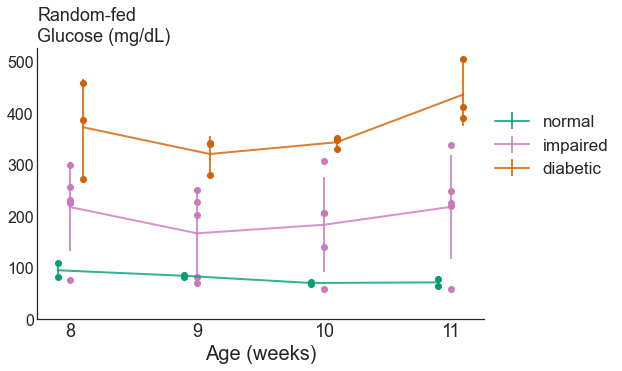

In [630]:
df = ap.loc[:, ap.filter(regex='^RBG').columns].iloc[:, 1:-1]
rbg_weeks_fig, rbg_weeks_ax = \
make_metadata_plot(df, [8,9,10,11], 
                   xlabel='Age (weeks)',
                   ylabel='Random-fed\nGlucose (mg/dL)', 
                   offsets=[-0.1, 0, 0.1])
plt.ylim(bottom=0)

plt.savefig(r'..\reports\figures\0-1-1\RBG_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\RBG_weeks.png', bbox_inches='tight')

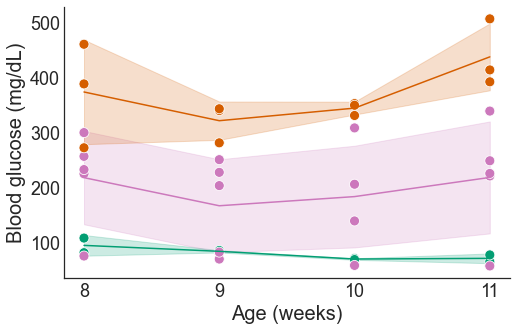

In [631]:
rbg_fig, rbg_ax = make_ci_metadata_plot(dfs['RBG'], x='x', y='y')
plt.ylabel('Blood glucose (mg/dL)', fontsize=20)
plt.xlabel('Age (weeks)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_RBG_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_RBG_weeks.png', bbox_inches='tight')

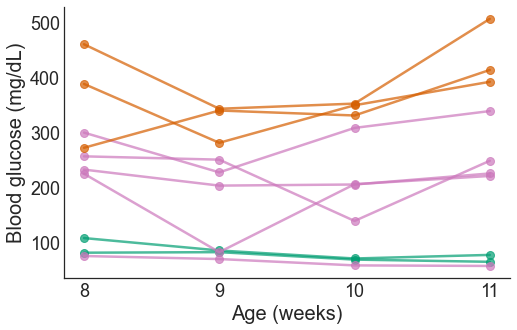

In [632]:
x = [8, 9, 10, 11]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='^RBG').columns[1:-1]].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', markersize=8, c=color, linewidth=2.5, 
            label=gluc_tol, alpha=0.7)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Blood glucose (mg/dL)', fontsize=20)

sns.despine()

plt.savefig(r'..\reports\figures\0-1-1\indiv_RBG.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\indiv_RBG.png', bbox_inches='tight')

## FBG over weeks

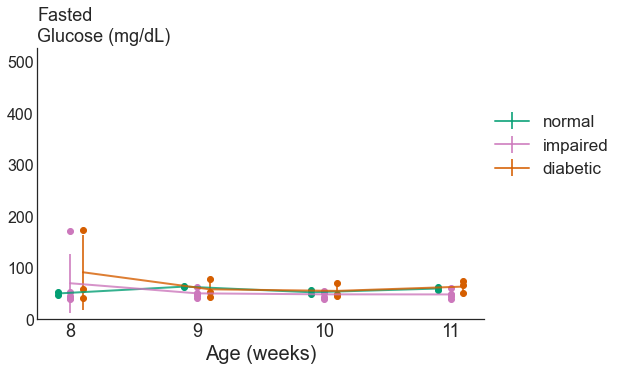

In [633]:
df = ap.loc[:, ap.filter(regex='^FBG').columns].iloc[:, :-1]
make_metadata_plot(df, [8,9,10,11], 
                   xlabel='Age (weeks)', ylabel='Fasted\nGlucose (mg/dL)', 
                   offsets=[-0.1, 0, 0.1])
plt.ylim(0, rbg_weeks_ax.get_ylim()[1])

plt.savefig(r'..\reports\figures\0-1-1\FBG_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\FBG_weeks.png', bbox_inches='tight')

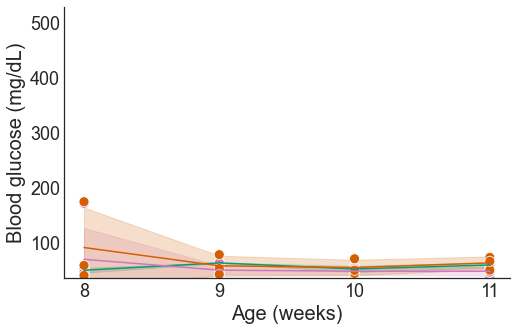

In [634]:
# df = dfs['FBG']
# df = df.loc[df['FBG'] != 8]
fbg_fig, fbg_ax = make_ci_metadata_plot(dfs['FBG'], x='x', y='y')
plt.ylim(rbg_ax.get_ylim())
plt.ylabel('Blood glucose (mg/dL)', fontsize=20)
plt.xlabel('Age (weeks)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_FBG_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_FBG_weeks.png', bbox_inches='tight')

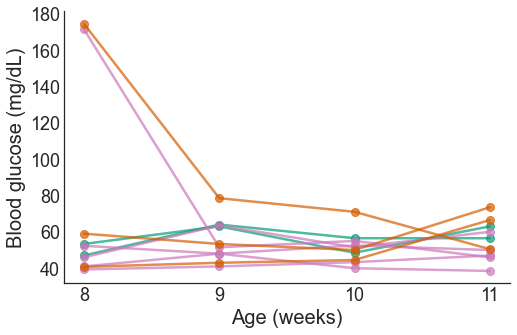

In [635]:
x = [8, 9, 10, 11]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='^FBG').columns[:-1]].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', markersize=8, c=color, linewidth=2.5, 
            label=gluc_tol, alpha=0.7)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Blood glucose (mg/dL)', fontsize=20)

sns.despine()

plt.savefig(r'..\reports\figures\0-1-1\indiv_FBG.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\indiv_FBG.png', bbox_inches='tight')

# Figure 1C: Body weight averaged by glucose tolerance category
## Use non-fasted weights

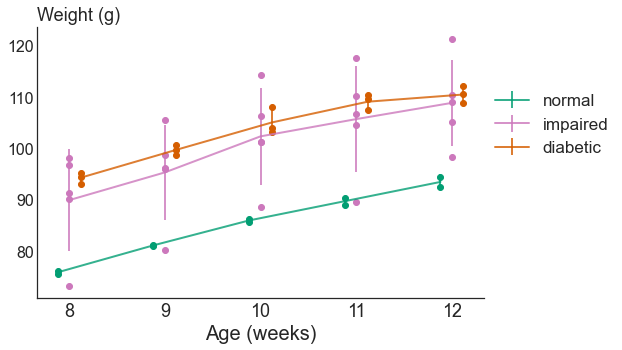

In [636]:
df = ap.loc[:, ap.filter(regex='Weightprefast').columns]
make_metadata_plot(df, [8,9,10,11,12], xlabel='Age (weeks)', ylabel='Weight (g)')

plt.savefig(r'..\reports\figures\0-1-1\weight_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\weight_weeks.png', bbox_inches='tight')

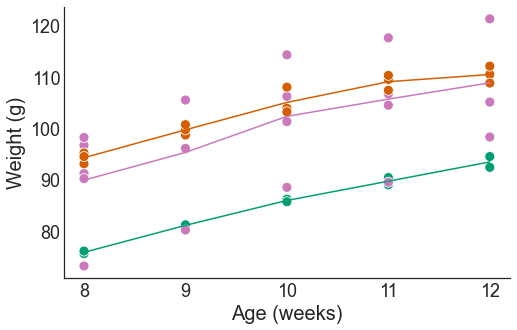

In [637]:
make_ci_metadata_plot(dfs['weight'], x='x', y='y', ci=None)
plt.ylabel('Weight (g)', fontsize=20)
plt.xlabel('Age (weeks)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_weight_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_weight_weeks.png', bbox_inches='tight')

In [638]:
dfs['weight'].pivot(columns='x', values='y', index='animal')

x,8,9,10,11,12
animal,,,,,
1060,90.2,96.0,101.3,104.5,105.1
1062,91.2,96.1,101.3,106.7,109.1
1074,96.7,98.7,106.2,110.1,110.4
1076,95.2,100.7,103.2,110.3,112.1
1082,94.5,99.7,103.9,107.4,108.8
1091,76.1,81.2,86.2,89.0,92.4
1092,73.2,80.2,88.5,89.5,98.3
1093,75.6,81.0,85.7,90.4,94.5
1101,93.1,98.7,108.0,109.5,110.5


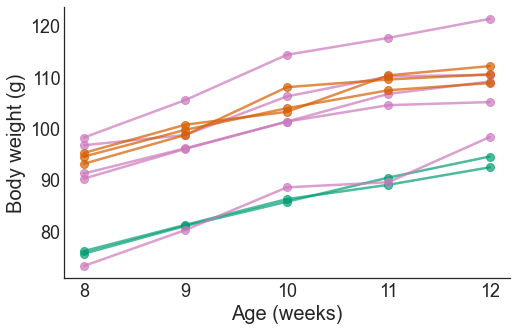

In [639]:
x = [8, 9, 10, 11, 12]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='prefast').columns].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', markersize=8, c=color, linewidth=2.5, 
            label=gluc_tol, alpha=0.7)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Body weight (g)', fontsize=20)

sns.despine()

plt.savefig(r'..\reports\figures\0-1-1\indiv_weight.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\indiv_weight.png', bbox_inches='tight')

# Figure 1D
## Area under Curve of OGTT 

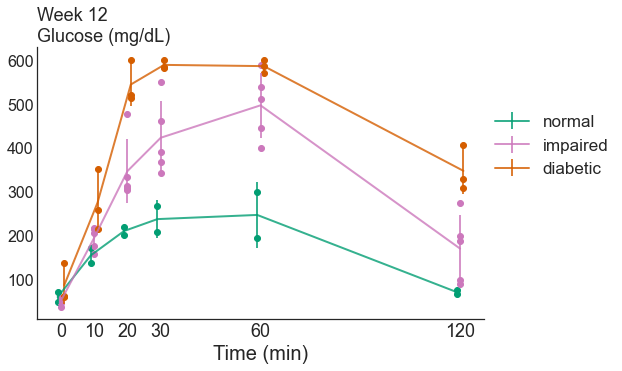

In [640]:
df = ap.loc[:, ap.filter(regex='OGTT\(').columns]
ogtt_fig, ogtt_ax = make_metadata_plot(df, [0,10,20,30,60,120], xlabel='Time (min)', 
                                       ylabel='Week 12\nGlucose (mg/dL)', offsets=[-1, 0, 1])

plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUC.png', bbox_inches='tight')

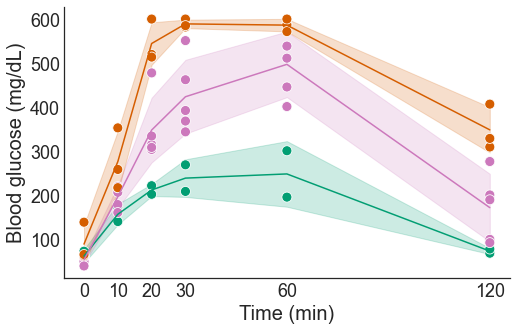

In [641]:
fig, ax = make_ci_metadata_plot(dfs['OGTT'], x='x', y='y')
plt.xlabel('Time (min)', fontsize=20)
plt.ylabel('Blood glucose (mg/dL)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_OGTT_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_OGTT_AUC.png', bbox_inches='tight')

# Figure 1
## bar plots explaining OGTT AUC cut-offs

In [642]:
ap.loc[ap.index.isin(animals_used), ['OGTT (AUC)', 'Insulin (AUC)']]

,OGTT (AUC),Insulin (AUC)
animal,,
1060,48742.5,422.940
1062,43717.5,432.020
1074,35250.0,626.660
1076,60245.0,238.005
1082,56462.5,198.650
1091,19060.0,653.495
1092,34022.5,1316.550
1093,25057.5,453.485
1101,55007.5,153.906


# There might be errors in how OGTT AUC and Insulin AUC were calculated in the original documents 

In [643]:
from scipy.integrate import simpson

In [651]:
ins = ap.loc[ap.index.isin(animals_used), ap.filter(regex='Insulin\(').columns]
ins['ins_trapz'] = ins.apply(lambda row: np.trapz(row, x=[0, 10, 20, 30, 60, 120]), axis=1)

ogtt = ap.loc[ap.index.isin(animals_used), ap.filter(regex='OGTT\(').columns]
trapz = ogtt.apply(lambda row: np.trapz(row, x=[0, 10, 20, 30, 60, 120]), axis=1)
# midpoint = ogtt.apply(lambda row: midpoint(row), axis=1)
ogtt['simpson'] = ogtt.apply(lambda row: simpson(row, x=[0, 10, 20, 30, 60, 120]), axis=1)
ogtt['trapz'] = trapz 
# ogtt['midpoint'] = midpoint

bar_data = ap.loc[ap.index.isin(animals_used), 
                  ['OGTT (AUC)', 'Insulin (AUC)', 'glucose_tolerance']].sort_values('OGTT (AUC)')
bar_data['animal'] = bar_data.index.astype('str')
bar_data['color'] = bar_data['glucose_tolerance'].map(colors)
bar_data['loc'] = range(10)
bar_data = bar_data.join(ins['ins_trapz'])
bar_data = bar_data.join(ogtt[['trapz', 'simpson']])
bar_data

,OGTT (AUC),Insulin (AUC),glucose_tolerance,animal,color,loc,ins_trapz,trapz,simpson
animal,,,,,,,,,
1091,19060.0,653.495,normal,1091,"[0.00784313725490196, 0.6196078431372549, 0.45...",0,653.495,19060.0,19582.152778
1093,25057.5,453.485,normal,1093,"[0.00784313725490196, 0.6196078431372549, 0.45...",1,453.485,25057.5,26385.486111
1092,34022.5,1316.550,impaired,1092,"[0.8, 0.47058823529411764, 0.7372549019607844]",2,1316.550,34022.5,35797.708333
1074,35250.0,626.660,impaired,1074,"[0.8, 0.47058823529411764, 0.7372549019607844]",3,626.660,35250.0,37381.180556
1062,43717.5,432.020,impaired,1062,"[0.8, 0.47058823529411764, 0.7372549019607844]",4,432.020,43717.5,45972.638889
1102,46565.0,377.030,impaired,1102,"[0.8, 0.47058823529411764, 0.7372549019607844]",5,377.030,46565.0,48102.708333
1060,48742.5,422.940,impaired,1060,"[0.8, 0.47058823529411764, 0.7372549019607844]",6,422.940,48742.5,51694.444444
1101,55007.5,153.906,diabetic,1101,"[0.8352941176470589, 0.3686274509803922, 0.0]",7,153.906,55007.5,56516.944444
1082,56462.5,198.650,diabetic,1082,"[0.8352941176470589, 0.3686274509803922, 0.0]",8,198.650,56462.5,57378.750000


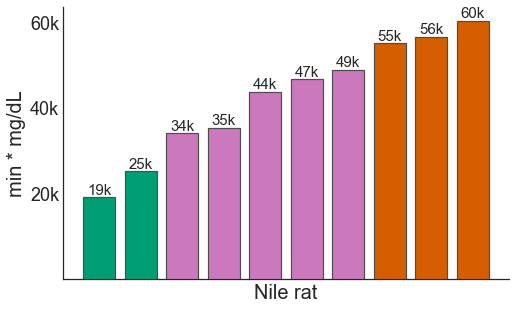

In [678]:
plt.gcf().set_size_inches(8, 5)
plt.bar(x=bar_data['loc'], height=bar_data['OGTT (AUC)'], 
        color=bar_data['color'].to_list(), edgecolor=(0.3, 0.3, 0.3), linewidth=1.2,
        width=0.77,
        zorder=10)
for loc, ogtt in zip(bar_data['loc'], bar_data['OGTT (AUC)']):
    plt.annotate(str(int(round(ogtt, -3)))[:2] + 'k', xy=(loc, ogtt+800), ha='center', fontsize=15, zorder=9)
    
plt.xlabel('Nile rat', fontsize=20)
plt.xticks([])
plt.ylabel('min * mg/dL', fontsize=20)
# plt.yticks(fontsize=16)
plt.yticks([20000, 40000, 60000], labels=['20k', '40k', '60k'], fontsize=18)
plt.ylim(0, plt.ylim()[1] + 200)
# plt.axhline(y=1000, c=(0.1, 0.1, 0.1))
# plt.axhline(y=2000, c=(0.1, 0.1, 0.1))
# plt.axhspan(ymin=0, ymax=1000, color=(0.9, 0.9, 0.9))
# plt.axhspan(ymin=1000, ymax=2000, color=(0.83, 0.83, 0.83))
# plt.axhspan(ymin=2000, ymax=plt.ylim()[1], color=(0.75, 0.75, 0.75))
# plt.axhline(y=1000, color='gray', zorder=4)
# plt.axhline(y=2000, color='gray', zorder=5)
# plt.text(s='Normal', x=10, y=500, fontsize=20, va='center')
# plt.text(s='Impaired', x=10, y=1500, fontsize=20, va='center')
# plt.text(s='Diabetic', x=10, y=2300, fontsize=20, va='center')

sns.despine()

fig.set_facecolor('white')

# plt.savefig(r'..\reports\figures\0-1-1\bar_OGTT_AUC.svg', bbox_inches='tight', dpi=300)
# plt.savefig(r'..\reports\figures\0-1-1\bar_OGTT_AUC.png', bbox_inches='tight', dpi=300)

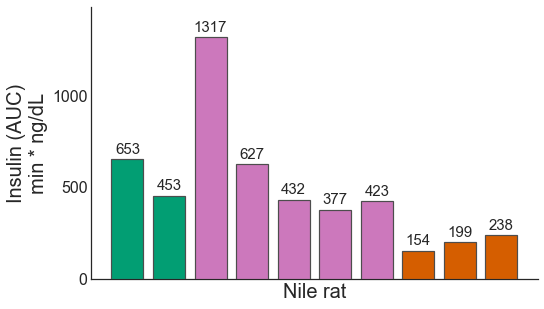

In [674]:
plt.gcf().set_size_inches(8, 5)
plt.bar(x=bar_data['loc'], height=bar_data['Insulin (AUC)'], 
        color=bar_data['color'].to_list(), edgecolor=(0.3, 0.3, 0.3), linewidth=1.2,
        width=0.77,
        zorder=10)
for loc, ogtt in zip(bar_data['loc'], bar_data['Insulin (AUC)']):
    plt.annotate(str(round(ogtt)), xy=(loc, ogtt+30), ha='center', fontsize=15, zorder=9)
    
plt.xlabel('Nile rat', fontsize=20)
plt.xticks([])
plt.ylabel('Insulin (AUC)\nmin * ng/dL', fontsize=20)
plt.yticks(ticks=[0, 500, 1000], fontsize=16)
plt.ylim(0, plt.ylim()[1] + 100)
# plt.axhspan(ymin=0, ymax=1000, color=(0.9, 0.9, 0.9))
# plt.axhspan(ymin=1000, ymax=2000, color=(0.83, 0.83, 0.83))
# plt.axhspan(ymin=2000, ymax=plt.ylim()[1], color=(0.75, 0.75, 0.75))
# plt.axhline(y=1000, color='gray', zorder=4)
# plt.axhline(y=2000, color='gray', zorder=5)
# plt.text(s='Normal', x=10, y=500, fontsize=20, va='center')
# plt.text(s='Impaired', x=10, y=1500, fontsize=20, va='center')
# plt.text(s='Diabetic', x=10, y=2300, fontsize=20, va='center')

sns.despine()

fig.set_facecolor('white')

In [ ]:
np.trapz(ins.iloc[0], x=[0, 10, 20, 30, 60, 120])

# Figure 1E
## Area under Curve of Insulin

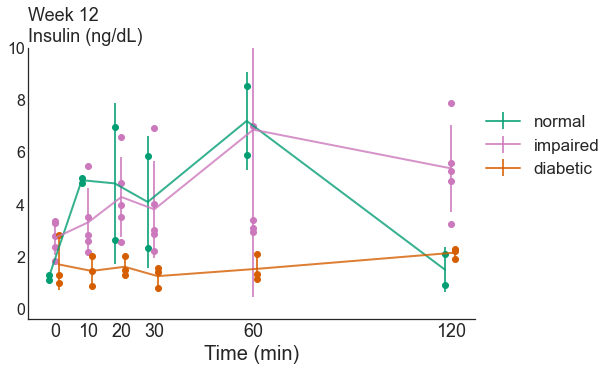

In [645]:
df = ap.loc[ap['lcms_sampled'], ap.filter(regex='Insulin\(').columns]
insulin_auc_fig, insulin_auc_ax = make_metadata_plot(df, [0,10,20,30,60,120], xlabel='Time (min)', 
                                       ylabel='Week 12\nInsulin (ng/dL)', offsets=[-2, 0, 1])
plt.ylim(top=10)

plt.savefig(r'..\reports\figures\0-1-1\insulin_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\insulin_AUC.png', bbox_inches='tight')

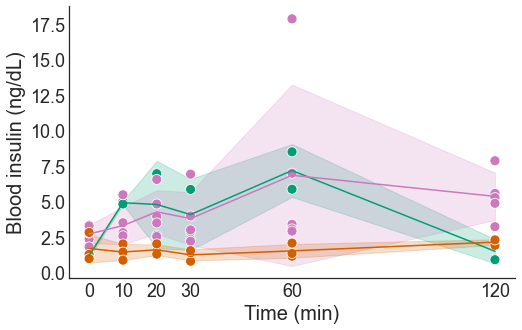

In [646]:
make_ci_metadata_plot(dfs['Insulin'], x='x', y='y')
plt.xlabel('Time (min)', fontsize=20)
plt.ylabel('Blood insulin (ng/dL)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_insulin_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_insulin_AUC.png', bbox_inches='tight')

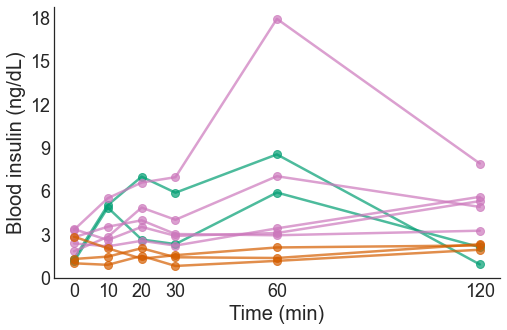

In [647]:
x = [0, 10, 20, 30, 60, 120]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='Insulin\(').columns].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', markersize=8, c=color, linewidth=2.5, 
            label=gluc_tol, alpha=0.7)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Time (min)', fontsize=20)
plt.yticks(ticks=range(0, 20, 3), fontsize=18)
plt.ylabel('Blood insulin (ng/dL)', fontsize=20)

sns.despine()

plt.savefig(r'..\reports\figures\0-1-1\indiv_insulin_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\indiv_insulin_AUC.png', bbox_inches='tight')

# Figure 1F: Insulin plots


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


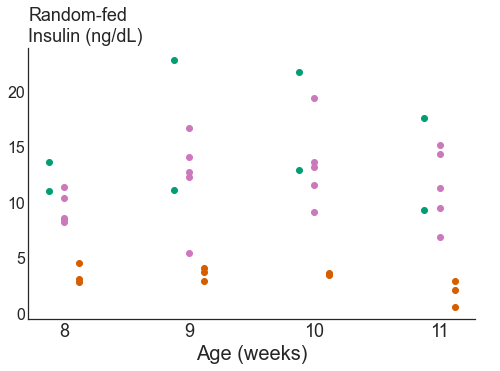

In [525]:
df = ap.loc[:,ap.filter(regex='InsulinRBG').columns].iloc[:, :-1]
make_metadata_plot(df, [8,9,10,11], xlabel='Age (weeks)', ylabel='Random-fed\nInsulin (ng/dL)', errorbar=False)
rbg_insulin_ylim = plt.ylim()

# plt.savefig(r'..\reports\figures\0-1-1\RBG_insulin_weeks.svg', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\0-1-1\RBG_insulin_weeks.png', bbox_inches='tight')

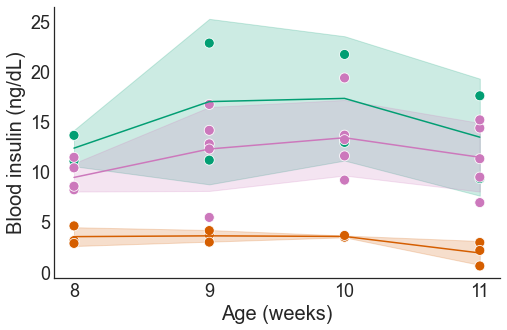

In [482]:
rinsulin_fig, rinsulin_ax = make_ci_metadata_plot(dfs['Rinsulin'], x='x', y='y')
# plt.ylim(rbg_ax.get_ylim())
plt.ylabel('Blood insulin (ng/dL)', fontsize=20)
plt.xlabel('Age (weeks)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_RBG_insulin_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_RBG_insulin_weeks.png', bbox_inches='tight')

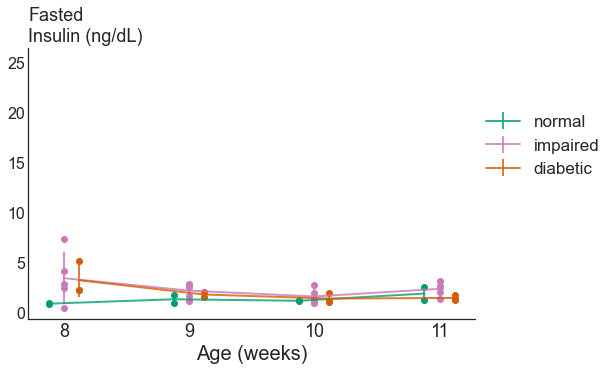

In [483]:
df = ap.loc[:,ap.filter(regex='InsulinFBG').columns].iloc[:, :-1]
make_metadata_plot(df, [8,9,10,11], xlabel='Age (weeks)', ylabel='Fasted\nInsulin (ng/dL)')
plt.ylim(rbg_insulin_ylim)

plt.savefig(r'..\reports\figures\0-1-1\FBG_insulin_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\FBG_insulin_weeks.png', bbox_inches='tight')

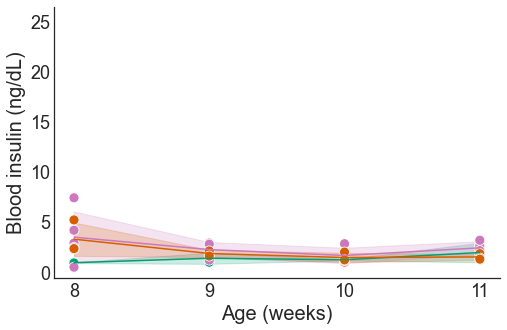

In [484]:
make_ci_metadata_plot(dfs['Finsulin'], x='x', y='y')
plt.ylim(rinsulin_ax.get_ylim())
plt.ylabel('Blood insulin (ng/dL)', fontsize=20)
plt.xlabel('Age (weeks)', fontsize=20)

plt.savefig(r'..\reports\figures\0-1-1\new_FBG_insulin_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\new_FBG_insulin_weeks.png', bbox_inches='tight')

In [537]:
ap.columns

Index(['Date of birth', 'litter', 'lcms_sampled', 'glucose_tolerance',
       'OGTT(0min)', 'OGTT(10min)', 'OGTT(20min)', 'OGTT(30min)',
       'OGTT(60min)', 'OGTT(120min)', 'OGTT (AUC)', 'Insulin(0min)',
       'Insulin(10min)', 'Insulin(20min)', 'Insulin(30min)', 'Insulin(60min)',
       'Insulin(120min)', 'Insulin (AUC)', 'RBGweek4', 'RBGweek8', 'RBGweek9',
       'RBGweek10', 'RBGweek11', 'RBGweek12', 'FBGweek8', 'FBGweek9',
       'FBGweek10', 'FBGweek11', 'FBGweek12', 'InsulinFBGweek8',
       'InsulinFBGweek9', 'InsulinFBGweek10', 'InsulinFBGweek11',
       'InsulinFBGweek12', 'InsulinRBGweek8', 'InsulinRBGweek9',
       'InsulinRBGweek10', 'InsulinRBGweek11', 'InsulinRBGweek12',
       'WeightRBGweek4', 'WeightRBGweek8', 'WeightRBGweek9', 'WeightRBGweek10',
       'WeightRBGweek11', 'WeightRBGweek12', 'WeightFBGweek8',
       'WeightFBGweek9', 'WeightFBGweek10', 'WeightFBGweek11',
       'WeightFBGweek12', 'Weightprefastweek8', 'Weightprefastweek9',
       'Weightprefastweek10

In [541]:
ap.filter(regex='InsulinF').columns

Index(['InsulinFBGweek8', 'InsulinFBGweek9', 'InsulinFBGweek10',
       'InsulinFBGweek11', 'InsulinFBGweek12'],
      dtype='object')

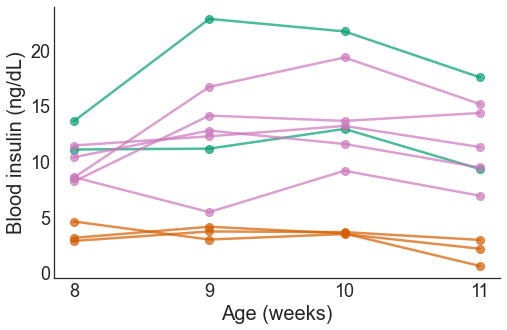

In [543]:
x = [8, 9, 10, 11]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='InsulinR').columns[:-1]].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', markersize=8, c=color, linewidth=2.5, 
            label=gluc_tol, alpha=0.7)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Blood insulin (ng/dL)', fontsize=20)

sns.despine()

plt.savefig(r'..\reports\figures\0-1-1\indiv_Rinsulin.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\indiv_Rinsulin.png', bbox_inches='tight')

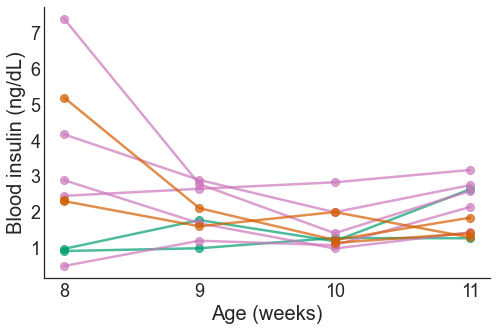

In [544]:
x = [8, 9, 10, 11]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='InsulinF').columns[:-1]].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', markersize=8, c=color, linewidth=2.5, 
            label=gluc_tol, alpha=0.7)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Blood insulin (ng/dL)', fontsize=20)

sns.despine()

plt.savefig(r'..\reports\figures\0-1-1\indiv_Finsulin.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\indiv_Finsulin.png', bbox_inches='tight')

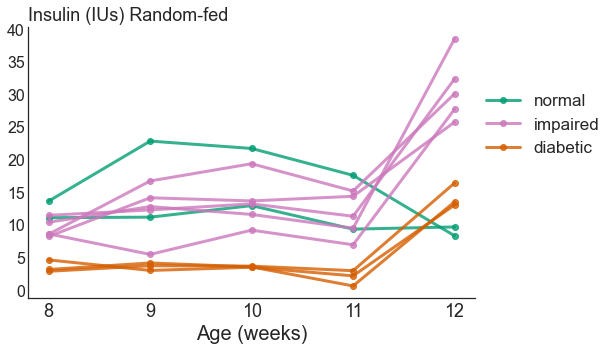

In [679]:
x = [8, 9, 10, 11, 12]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='InsulinRBG').columns].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', c=color, linewidth=3, label=gluc_tol, alpha=0.8)
#     ax.errorbar(x, df, yerr=2)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=16)
# ax.set_ylabel('Insulin (IUs)', fontsize=20, loc='top')
ax.set_title('Insulin (IUs) Random-fed', fontsize=18, loc='left')
# fig.suptitle('Insulin (Random-fed)', fontsize=22)

h, l = ax.get_legend_handles_labels()
handles = [h[0], h[2], h[-1]]
labels = [l[0], l[2], l[-1]]
plt.legend(handles, labels, loc=(1.01, 0.5), fontsize=17)
sns.despine()

# Combined figures 

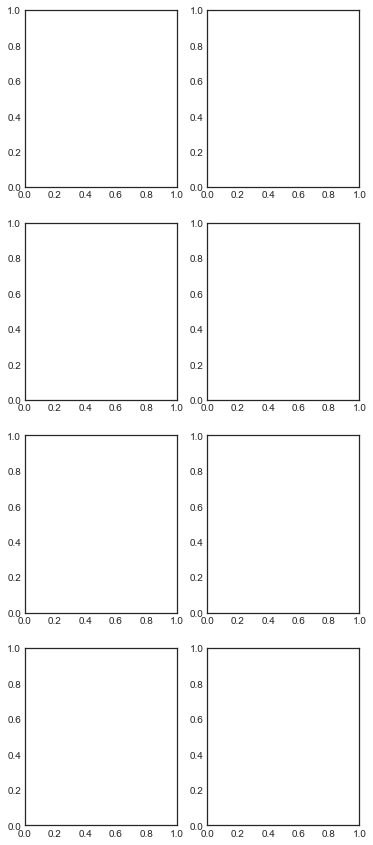

In [680]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(6, 15)

axs[0][0] = ax

# Figure 1F: OGTT vs Insulin plot with best fit line

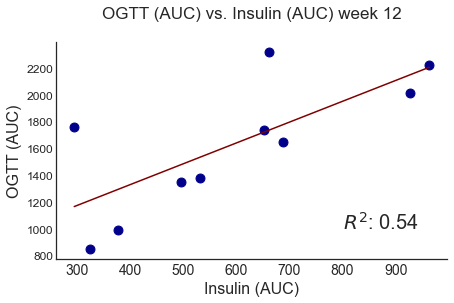

In [337]:
ogtt_vs_insulin = ap.loc[ap['lcms_sampled']]
ogtt_insulin_regres = LinearRegression().fit(ogtt_vs_insulin['Insulin (AUC)'].values.reshape(-1, 1), 
                                             ogtt_vs_insulin['OGTT (AUC)'].values.reshape(-1, 1))
ovi_slope = ogtt_insulin_regres.coef_.item()
ovi_intercept = ogtt_insulin_regres.intercept_.item()
ovi_r2 = ogtt_insulin_regres.score(ogtt_vs_insulin['Insulin (AUC)'].values.reshape(-1, 1),
                                   ogtt_vs_insulin['OGTT (AUC)'].values.reshape(-1, 1))
ovi_r2

min_insulin = min(ogtt_vs_insulin['Insulin (AUC)'])
max_insulin = max(ogtt_vs_insulin['Insulin (AUC)'])

plt.plot(
    [min_insulin, max_insulin], 
    [ovi_intercept + min_insulin*ovi_slope, ovi_intercept + max_insulin*ovi_slope],
    c='maroon'
)
plt.scatter(
    ogtt_vs_insulin['Insulin (AUC)'], 
    ogtt_vs_insulin['OGTT (AUC)'], 
    s=80, 
    c='darkblue')
plt.annotate('$R^2$: ' + str(round(ovi_r2, 2)), xy=(800, 1000), fontsize=20)
plt.xlabel('Insulin (AUC)', fontsize=16)
plt.ylabel('OGTT (AUC)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.title('OGTT (AUC) vs. Insulin (AUC) week 12\n', fontsize=17)
plt.gcf().set_size_inches(7, 4)

### The normal/impaired/diabetic classification came from the oral glucose test (OGTT) 

The OGTT area under curve (AUC) gives the integration of the OGTT blood glucose test based on the time points between 0 and 120 minutes 

### Use a K-means clustering method to derive cut-off values for k groups of glucose tolerance 

Because K-means uses a distance metric, it is suggested to use Standardized data. However, based on the shape of the graphs below elbow plots below, it doesn't make a difference as to the number of clusters. 

In [338]:
ogtt_auc = np.array(animal_phenotypes.loc[animal_phenotypes['OGTT (AUC)'].notna(), 'OGTT (AUC)']).reshape(-1, 1)
print(ogtt_auc)
ss_errors = []
ss_errors_scaled = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='random', random_state=1000)
    kmeans.fit(ogtt_auc)
    ss_errors.append(kmeans.inertia_)
    
    kmeans_scaled = KMeans(n_clusters=k, init='random', random_state=1000)
    kmeans_scaled.fit(StandardScaler().fit_transform(ogtt_auc))
    ss_errors_scaled.append(kmeans_scaled.inertia_)

plt.plot(range(2, 10), ss_errors)
plt.ylabel('Sum of squares error')
plt.xlabel('Number of K-means clusters')
plt.title('Elbow plot of K-means clusters')

# plt.figure()
# plt.plot(range(2, 10), ss_errors_scaled)

NameError: name 'animal_phenotypes' is not defined

In [ ]:
ogtt_auc.reshape(-1)

In [37]:
ogtt_auc_animals_used = ap.loc[ap.index.isin(animals_used), 'OGTT (AUC)']
ogtt_auc_animals_used

animal
1060    1761.75
1062    1648.75
1074    1350.25
1076    2321.25
1082    2224.75
1091     846.75
1092    1377.95
1093     993.00
1101    2015.75
1102    1738.25
Name: OGTT (AUC), dtype: float64

In [38]:
ogtt_auc_animals_not_used = ap.loc[~ap.index.isin(animals_used), 'OGTT (AUC)'].dropna()
ogtt_auc_animals_not_used

animal
1061    1674.80
1075    3365.00
1081    2354.75
1094     842.75
1096    1401.25
Name: OGTT (AUC), dtype: float64

In [39]:
ogtts = ap.loc[ap['OGTT (AUC)'].notna(), 'OGTT (AUC)']
ogtt_auc = ogtts.values.reshape(-1, 1)

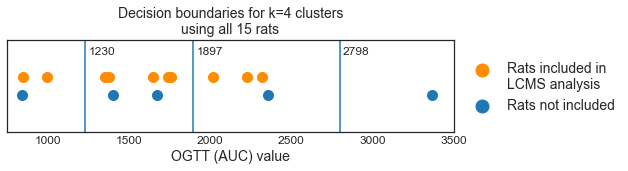

In [63]:
# Plot OGTT AUC data on 1-D plot, with decision boundaries

test_data = np.arange(3500).reshape(-1, 1)

# kmeans_2 = KMeans(n_clusters=2, init='random', random_state=1000)
# kmeans_2.fit(ogtt_auc)

# plt.gcf().set_size_inches((7, 2))
# plt.scatter(ogtt_auc.reshape(-1), [0]*15)
# plt.xlim((750, 3500))
# plt.ylim((-0.01, 0.01))
# k2_pred = list(kmeans_2.predict(test_data))
# # From the test data, get the .index of the first instance of each cluster, giving the boundary line
# for index in range(0, 2):
#     plt.vlines(k2_pred.index(index), ymin=-1, ymax=1)
# plt.yticks([])
# plt.xlabel('OGTT (AUC) value')
# plt.title('Decision boundaries for k=2 clusters\nusing all 15 rats')


# kmeans_3 = KMeans(n_clusters=3, init='random', random_state=1000)
# kmeans_3.fit(ogtt_auc)
# plt.figure()
# plt.gcf().set_size_inches((7, 2))
# plt.scatter(ogtt_auc.reshape(-1), [0]*15)
# plt.xlim((700, 3500))
# plt.ylim((-0.01, 0.01))
# k3_pred = list(kmeans_3.predict(test_data))
# # From the test data, get the .index of the first instance of each cluster, giving the boundary line
# for index in range(0, 3):
#     plt.vlines(k3_pred.index(index), ymin=-1, ymax=1)
# plt.yticks([])
# plt.xlabel('OGTT (AUC) value')
# plt.title('Decision boundaries for k=3 clusters\nusing all 15 rats')


kmeans_4 = KMeans(n_clusters=4, init='random', random_state=1000)
kmeans_4.fit(ogtt_auc)
plt.figure()
plt.gcf().set_size_inches((8, 1.7))
plt.scatter(ogtt_auc_animals_used, [0.2]*10, s=100, c='darkorange', label='\nRats included in\nLCMS analysis')
plt.scatter(ogtt_auc_animals_not_used, [-0.2]*5, s=100, label='Rats not included')
plt.xlim((750, 3500))
plt.ylim((-1, 1))
k4_pred = list(kmeans_4.predict(test_data))
# From the test data, get the .index of the first instance of each cluster, giving the boundary line
for index in range(1, 4):
    plt.vlines(k4_pred.index(index), ymin=-1, ymax=1)
    plt.annotate(str(k4_pred.index(index)), xy=(k4_pred.index(index)+20, 0.69), fontsize=12)
plt.yticks([])
plt.xlabel('OGTT (AUC) value', fontsize=14)
plt.xticks(fontsize=12)
plt.title('Decision boundaries for k=4 clusters\nusing all 15 rats', fontsize=14)
plt.legend(loc=(1.02, 0.15), fontsize=14, markerscale=1.3)

plt.savefig(r'..\reports\figures\0-1-1\glucose_tolerance_decision_boundaries.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\glucose_tolerance_decision_boundaries.png', bbox_inches='tight')

Text(0.5, 1.0, 'Decision boundaries for k=4 clusters\nusing all 15 rats')

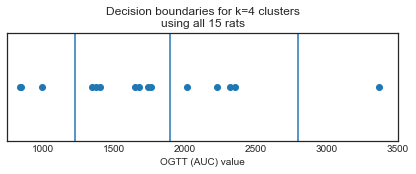

In [49]:
kmeans_4 = KMeans(n_clusters=4, init='random', random_state=1000)
kmeans_4.fit(ogtt_auc)

plt.gcf().set_size_inches((7, 2))
plt.scatter(ogtt_auc, [0]*15)
plt.xlim((750, 3500))
plt.ylim((-0.01, 0.01))
k4_pred = list(kmeans_4.predict(test_data))
# From the test data, get the .index of the first instance of each cluster, giving the boundary line
for index in range(1, 4):
    plt.vlines(k4_pred.index(index), ymin=-1, ymax=1)
plt.yticks([])
plt.xlabel('OGTT (AUC) value')
plt.title('Decision boundaries for k=4 clusters\nusing all 15 rats')

In [50]:
# pt = phenotypes of animals sampled for LCMS
pt = ap[ap.index.isin(animals_used)].sort_values('glucose_tolerance')
pt

,Date of birth,litter,lcms_sampled,glucose_tolerance,OGTT(0min),OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),...,Weightprefastweek12,HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
animal,,,,,,,,,,,,,,,,,,,,,
1076,2021-01-23,0,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,...,112.1,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
1082,2021-01-24,1,True,diabetic,62.0,258.0,600.0,600.0,571.5,328.5,...,108.8,NaN,0.8904,0.818382,0.6515,0.598805,1.366692,White,Yes,NaN
1101,2021-02-01,3,True,diabetic,64.5,216.5,519.5,582.0,587.0,309.0,...,110.5,NaN,0.9262,0.838190,0.6216,0.562534,1.490026,murky,Yes definitely,NaN
1060,2021-01-23,0,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,...,105.1,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
1062,2021-01-23,0,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,...,109.1,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
1074,2021-01-23,0,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,...,110.4,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
1092,2021-01-31,2,True,impaired,59.5,206.0,303.5,392.0,401.0,91.5,...,98.3,NaN,1.2902,1.312513,0.6312,0.642116,2.044043,clear,Slight,NaN
1102,2021-02-01,3,True,impaired,48.5,216.5,477.5,343.5,538.5,276.0,...,121.3,NaN,1.7053,1.405853,0.8780,0.723825,1.942255,murky,Very slight,NaN
1091,2021-01-31,2,True,normal,72.0,172.5,201.5,208.0,195.0,67.5,...,92.4,NaN,1.4930,1.615801,0.5354,0.579437,2.788569,clear,Slight,NaN


In [20]:
plt.scatter(pt['glucose_tolerance'], pt['OGTT (AUC)'])
plt.title('Oral glucose test Area Under Curve (AUC) per glucose tolerance')
plt.ylabel('AUC')

NameError: name 'pt' is not defined

In [21]:
plt.scatter(pt['Date of birth'], pt['OGTT (AUC)'])
plt.xticks(rotation=90)
plt.xlabel('Rat date of birth')
plt.ylabel('OGTT AUC')
plt.title('OGTT result by rat date of birth')# \n(Includes rats not sampled for LC-MS)')

NameError: name 'pt' is not defined

<AxesSubplot:xlabel='datetime'>

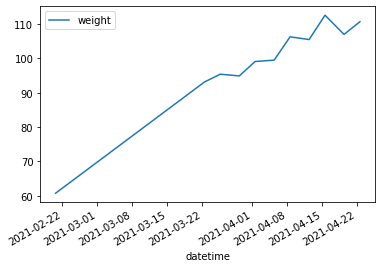

In [147]:
obs_used[(obs_used['weight type'] == 'Weight') & (obs_used['animal'] == 1076)][['datetime', 'weight']].plot('datetime', 'weight')

<AxesSubplot:xlabel='datetime'>

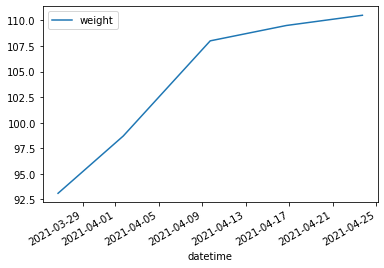

In [148]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['animal'] == 1101)][['datetime', 'weight']].plot('datetime', 'weight')

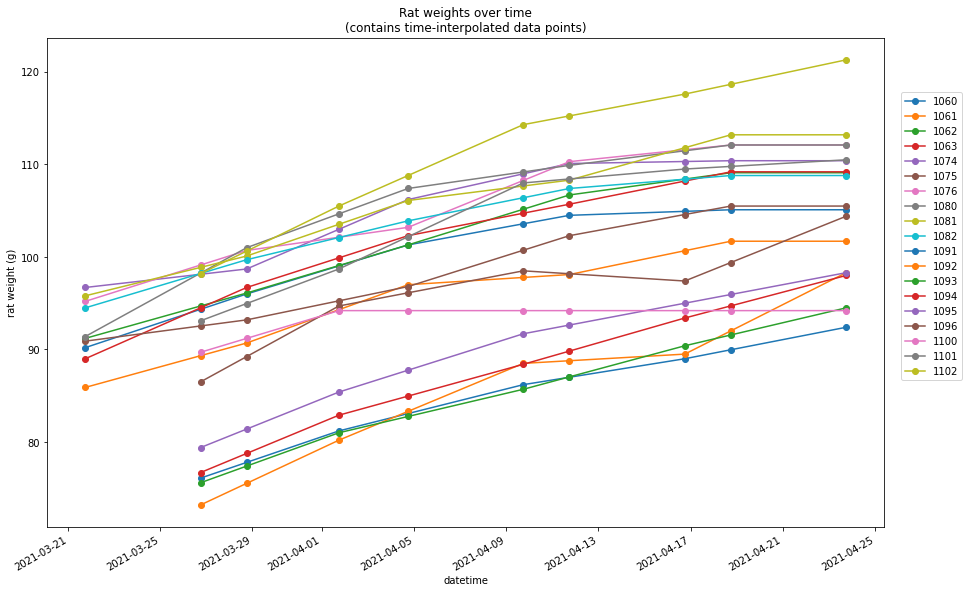

In [151]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'weight', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='weight')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 10)
plt.ylabel('rat weight (g)')
plt.title('Rat weights over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.02, 0.3))

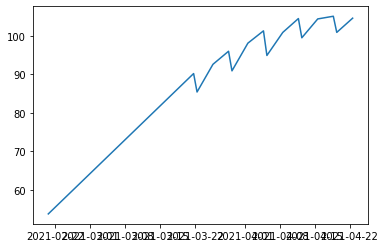

In [58]:
obs_used[obs_used['animal'] == 1060][['datetime', 'weight']]

plt.plot(obs_used[obs_used['animal'] == 1060][['datetime',]], obs_used[obs_used['animal'] == 1060][['weight']])

# OLD FIGURES 

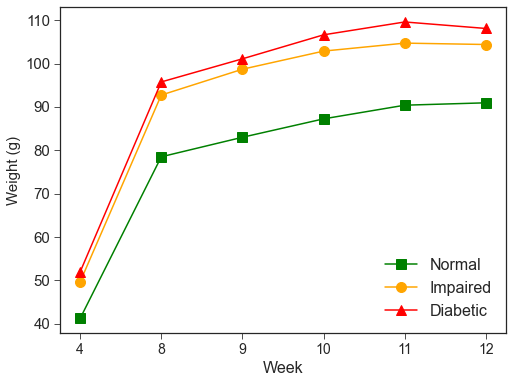

In [13]:
weight = obs.loc[(obs['weight type'] == 'Weight') & \
                  ((obs['BG type'] == 'RBG') | (obs['BG type'] == 'Post-OGTT BG'))] 
nweight = weight.loc[weight['animal'].isin(normal)].groupby('week').mean()['weight']
iweight = weight.loc[weight['animal'].isin(impaired)].groupby('week').mean()['weight']
dweight = weight.loc[weight['animal'].isin(diabetic)].groupby('week').mean()['weight']
nweight

weight_weeks = ['4','8','9','10','11','12']
plt.plot(weight_weeks, nweight, 's-',  label='Normal',   ms=10, c='green')
plt.plot(weight_weeks, iweight, 'o-',  label='Impaired', ms=10, c='orange')
plt.plot(weight_weeks, dweight, '^-',  label='Diabetic', ms=10, c='red')

plt.legend(fontsize=16)
plt.gcf().set_size_inches((8, 6))
plt.xticks(ticks=[0,1,2,3,4,5,], fontsize=14)
plt.xlabel('Week', fontsize=16)
plt.yticks(fontsize=15)
plt.ylabel('Weight (g)', fontsize=15)

ax2 = plt.gca()
# plt.plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=10, c='green',  )
# plt.plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=10, c='green',  )
# plt.plot(rbg_weeks, impaired_rbgs, 's-',  label='Random-fed\nimpaired', ms=10, c='orange', )
# print('')

## Combine Fig 1B and 1C into one 

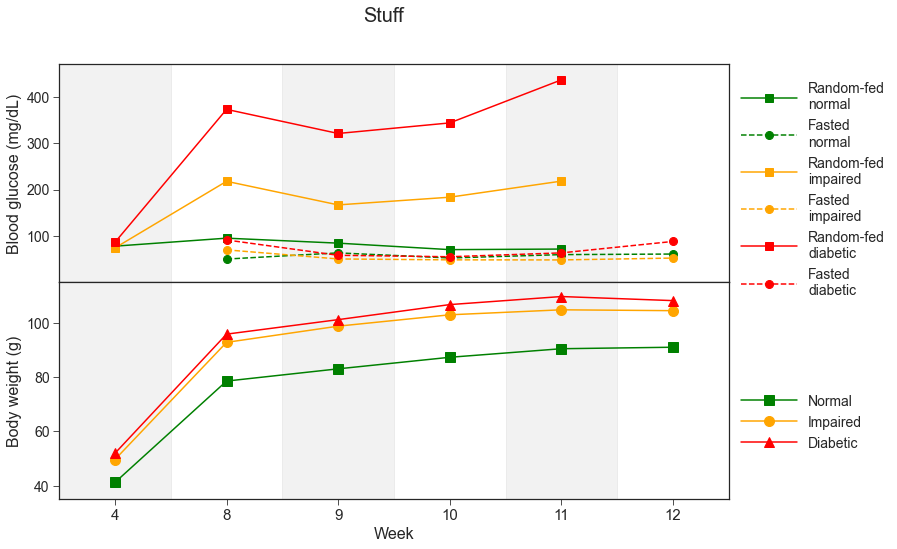

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.subplots_adjust(hspace=0.00)
# fig.xlim((0,10))
fig.set_size_inches((12, 8))
fig.suptitle('Stuff', fontsize=20)
# fig.supylabel('')
# plt.yticks(fontsize=15)

ax[0].plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=8, c='green',  )
ax[0].plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=8, c='green',  )
ax[0].plot(rbg_weeks, impaired_rbgs,   's-',  label='Random-fed\nimpaired', ms=8, c='orange', )
ax[0].plot(fbg_weeks, impaired_fbgs,   'o--', label='Fasted\nimpaired',     ms=8, c='orange', )
ax[0].plot(rbg_weeks, diabetic_rbgs,   's-',  label='Random-fed\ndiabetic', ms=8, c='red',    )
ax[0].plot(fbg_weeks, diabetic_fbgs,   'o--', label='Fasted\ndiabetic',     ms=8, c='red',    )
ax[0].legend(loc=(1.01, -0.1), fontsize=14, handlelength=4)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_ylabel('Blood glucose (mg/dL)', fontsize=16)
ax[0].set_ylim(1, 470)

# ax[0].set_xticks(ticks=[0,1,2,3,4,5])
# ax[0].set_xticklabels(labels=['4','8','9','10','11','12'])

ax[1].plot(weight_weeks, nweight, 's-',  label='Normal',   ms=10, c='green')
ax[1].plot(weight_weeks, iweight, 'o-',  label='Impaired', ms=10, c='orange')
ax[1].plot(weight_weeks, dweight, '^-',  label='Diabetic', ms=10, c='red')
ax[1].set_ylabel('Body weight (g)', fontsize=16)
ax[1].legend(loc=(1.01, 0.2), fontsize=14, handlelength=4)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].set_ylim(35, 115)

# Make nice gray backgrounds:
# for a in ax:
#     for i1, i2 in zip(np.arange(-0.5, 4.5, 2), np.arange(0.5, 5.5, 2)):
#         a.axvspan(i1, i2, color='gray', alpha=0.1)

plt.xticks(fontsize=15)
plt.xlabel('Week', fontsize=16)
plt.xlim(-0.5, 5.5)

plt.savefig(r'..\reports\figures\0-1-1\combined_metadata.svg')

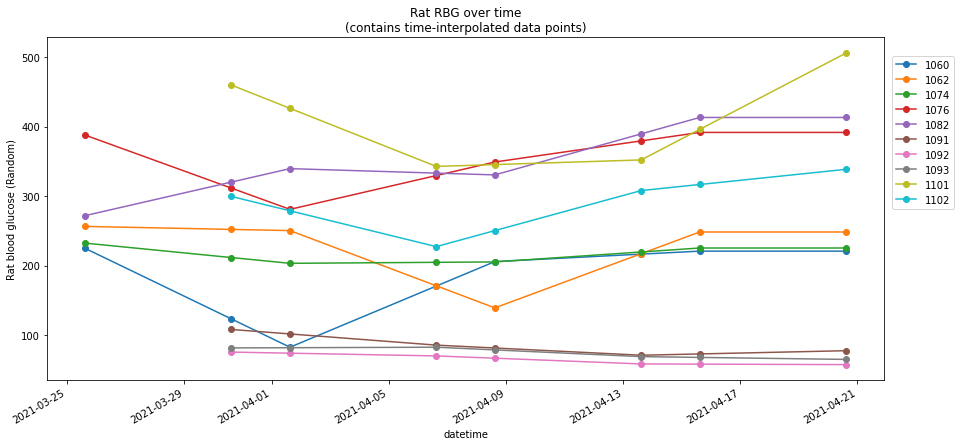

In [140]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .dropna(axis=0, how='all')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose (Random)')
plt.title('Rat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

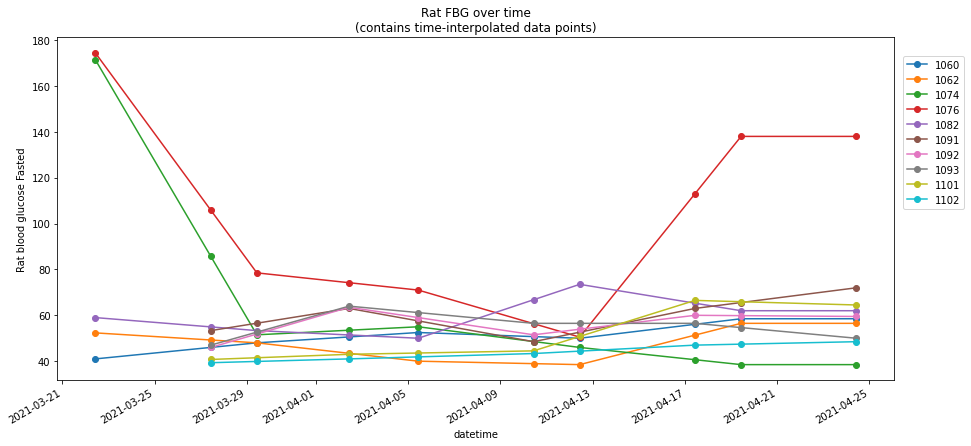

In [160]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Rat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

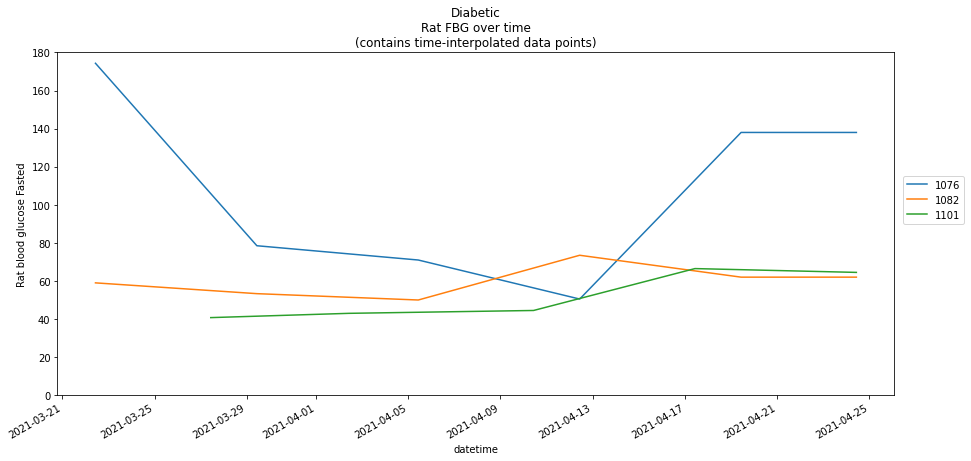

In [167]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

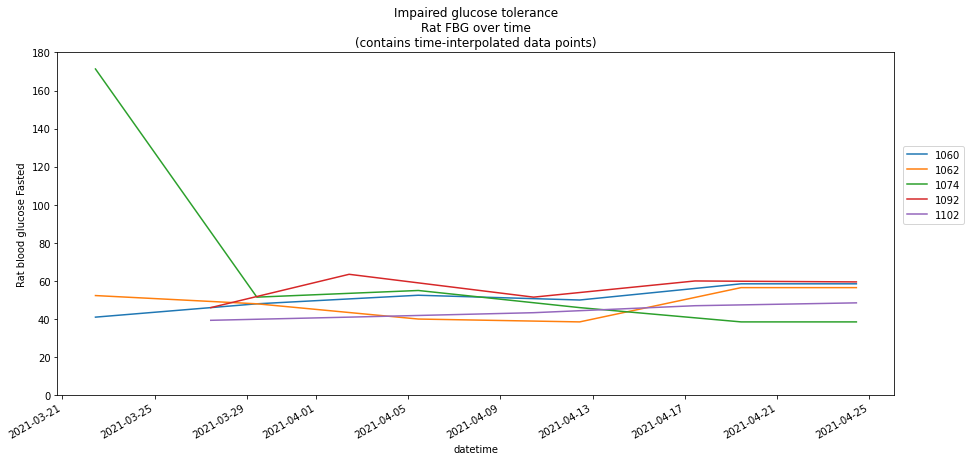

In [168]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

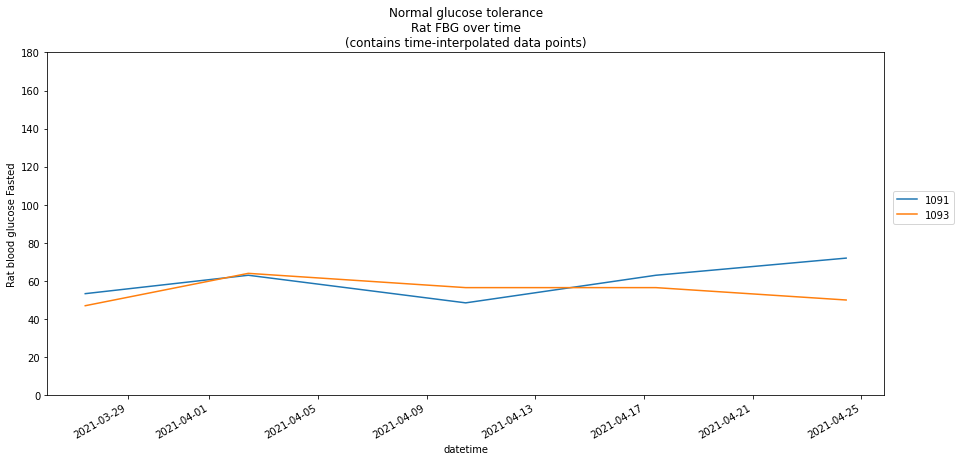

In [169]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

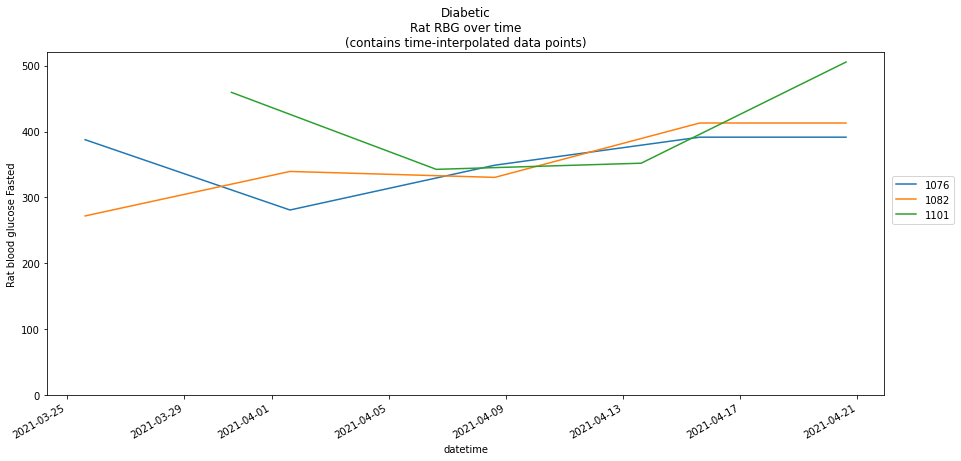

In [183]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

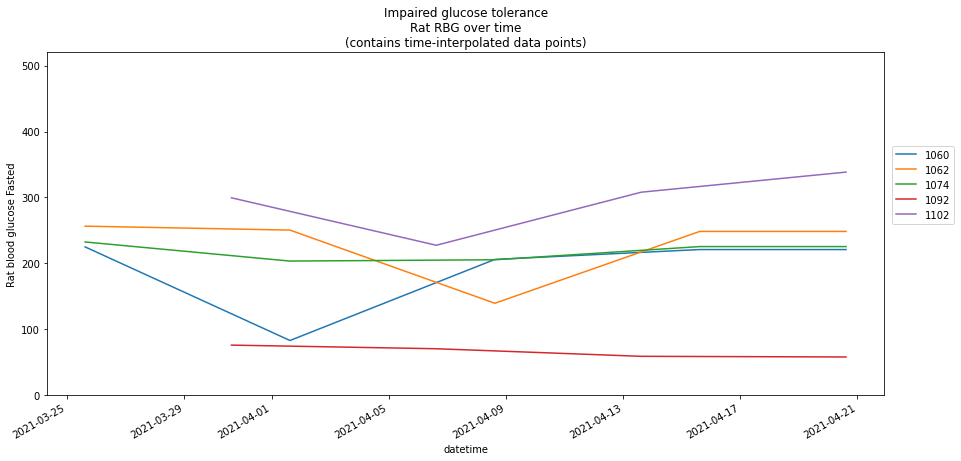

In [184]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

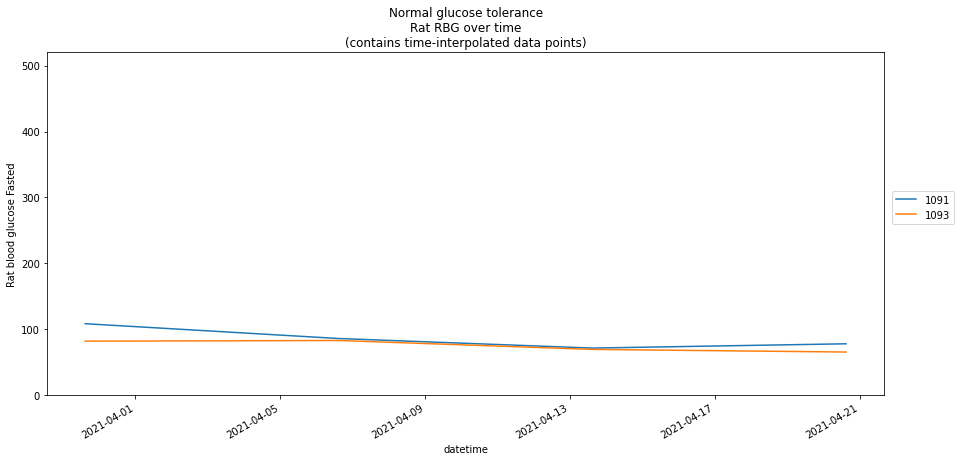

In [185]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

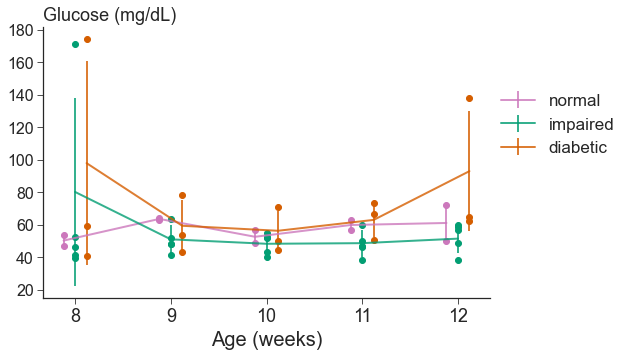

In [285]:
weeks = [8, 9, 10, 11, 12]
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
for gluc_tol, animals, offset in zip(['normal', 'impaired', 'diabetic'], 
                                     [normal, impaired, diabetic], 
                                     [-0.12, 0, 0.12]):
    df = ap.loc[animals, ap.filter(regex='^FBG').columns]
    for col in df:
        df.loc['min', col], df.loc['max', col] = min(df[col]), max(df[col])  # get max and min of each column in rows
    df.loc['mean'] = df.mean()
    color = colors[gluc_tol]
    xvals = [x + offset for x in weeks]
    ax.errorbar(
        xvals, 
        df.loc['mean'],
        yerr=df.std(),
#         yerr=abs(df.loc[['min', 'max']] - df.loc['mean']).values, # Important! Errors must be abs(+/-) from center
        linewidth=2, 
#         capsize=4, capthick=2,
        fmt='-', 
        c=color, alpha=0.8, label=gluc_tol)
    for animal in animals:
        ax.scatter(xvals, df.loc[animal], color=color)
plt.xticks(weeks, weeks, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=16)
ax.set_title('Glucose (mg/dL)', fontsize=18, loc='left')
plt.legend(loc=(1.01, 0.5), fontsize=17)
sns.despine()

In [270]:
ogtt = ap.loc[ap['animal'].isin(animals_used)].filter(regex='OGTT|animal').set_index('animal').iloc[:, :-1]
# ogtt = ap.filter(regex='OGTT|animal').set_index('animal').iloc[:, :-1]
nogtt = ogtt.loc[ogtt.index.isin(normal)]
iogtt = ogtt.loc[ogtt.index.isin(impaired)]
dogtt = ogtt.loc[ogtt.index.isin(diabetic)]

fig, ax = plt.subplots()
fig.set_size_inches((8, 5))

xnorm = [10, 20, 30, 60, 120]
xlabels = ['10', '\n20', '30', '60', '120']
ximp = [x + 160 for x in xnorm]
xdia = [x + 320 for x in xnorm]
for df, tol in zip([nogtt, iogtt, dogtt], ['n', 'i', 'd']):
    for i, row in df.iterrows():
        if tol == 'n':
            x = xnorm
        elif tol == 'i':
            x = ximp
        else:
            x = xdia
        plt.plot(x, row, '.-', alpha=0.6, lw=2.5, ms=10)
        # make an array of points in a line that connect start point to end point
#         plt.fill_between(x, y1=row, y2=0, alpha=0.1)

plt.ylabel('Blood glucose (mg/dL)', fontsize=16)
plt.yticks(fontsize=15)
plt.ylim(25, 620)
plt.xticks(ticks=(xnorm+ximp+xdia), labels=xlabels*3, fontsize=15);
plt.xlabel('Time (min)', fontsize=16)
plt.xlim(-10, 460)
# ax.axvspan(-10, 150, color='green', alpha=0.04, label='Normal')
# ax.axvspan(150, 300, color='orange', alpha=0.04, label='Impaired')
# ax.axvspan(300, 460, color='red', alpha=0.04, label='Diabetic')

# handles, labels = ax.get_legend_handles_labels()
# handles = [handle.set_fill('black') for handle in handles]
# ax.legend(loc=(1.01, 0.5), fontsize=15)
plt.annotate('Normal\nn=2',   (60,  50), fontsize=15, ha='center')
plt.annotate('Impaired\nn=5', (225, 50), fontsize=15, ha='center')
plt.annotate('Diabetic\nn=3', (380, 50), fontsize=15, ha='center')
plt.title('OGTT Test Results', fontsize=20)

# plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUCs.svg')

KeyError: 'animal'

Text(0.5, 1.0, 'Blood glucose measurements\nMean of diabetic status')

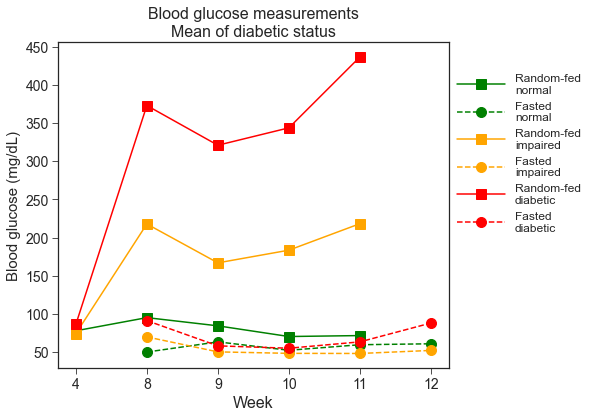

In [262]:
# Random 
nbg = obs.loc[(obs['animal'].isin(normal)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
normal_rbgs = nbg.groupby(by='week').mean()['BG']
ibg = obs.loc[(obs['animal'].isin(impaired)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
impaired_rbgs = ibg.groupby(by='week').mean()['BG']
dbg = obs.loc[(obs['animal'].isin(diabetic)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
diabetic_rbgs = dbg.groupby(by='week').mean()['BG']
# Fasted
nbg = obs.loc[(obs['animal'].isin(normal)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
normal_fbgs = nbg.groupby(by='week').mean()['BG']
ibg = obs.loc[(obs['animal'].isin(impaired)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
impaired_fbgs = ibg.groupby(by='week').mean()['BG']
dbg = obs.loc[(obs['animal'].isin(diabetic)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
diabetic_fbgs = dbg.groupby(by='week').mean()['BG']

plt.style.use('seaborn-ticks')

rbg_weeks = ['4','8','9','10','11']
fbg_weeks = ['8','9','10','11','12']
plt.plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=10, c='green',  )
plt.plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=10, c='green',  )
plt.plot(rbg_weeks, impaired_rbgs, 's-',  label='Random-fed\nimpaired', ms=10, c='orange', )
plt.plot(fbg_weeks, impaired_fbgs, 'o--', label='Fasted\nimpaired',     ms=10, c='orange', )
plt.plot(rbg_weeks, diabetic_rbgs, 's-',  label='Random-fed\ndiabetic', ms=10, c='red',    )
plt.plot(fbg_weeks, diabetic_fbgs, 'o--', label='Fasted\ndiabetic',     ms=10, c='red',    )

plt.legend(loc=(1.01, 0.4), handlelength=4, fontsize=12)
plt.gcf().set_size_inches((7, 6))
plt.xticks(ticks=[0,1,2,3,4,5], fontsize=14)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Blood glucose (mg/dL)', fontsize=15)
plt.yticks(fontsize=14)
plt.title('Blood glucose measurements\nMean of diabetic status', fontsize=16)